# FastFashOff - Détection de logos de fast fashion

Application de recherche d'image par contenu pour détecter les logos de marques de fast fashion et sensibiliser aux impacts sociaux et environnementaux.

**Projet réalisé dans le cadre du cours d'Informatique graphique et vision**  

## 1. Imports et configuration

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
   
#imports des modules de l'application
from config import LOGOS, IMAGES, LOGO_DIR, IMAGE_DIR, MIN_MATCHES, SEUIL_DISTANCE
from data_marques import MARQUES_INFO, LOGO_TO_MARQUE
from image_processing import load_image, filter_image, resize_image
from logo_detection import (extraire_features_orb,matcher_logos,filtrer_bons_matches,
valider_detection,dessiner_matches,valider_avec_homographie)
from display import afficher_info_boycott, afficher_image_opencv, afficher_resume
from utils import (valider_structure_projet,afficher_statistiques_detection,)

print("Modules chargés")


Modules chargés


In [ ]:
img = load_image(LOGO_DIR / LOGOS[0], grayscale=False)
print(img is not None, img.shape)

cv2.imread : False
load_image : False


## 2. Validation de la structure du projet


In [2]:
valide, message = valider_structure_projet()
print(message)

if valide:
    print("\nLogos disponibles :", len(LOGOS))
    for logo in LOGOS:
        print("- " + logo)
    
    print("\nImages disponibles :", len(IMAGES))
    for img in IMAGES:
        print("- " + img)

Structure du projet valide

Logos disponibles : 7
- Bershka-logo.png
- primark-logo.png
- zara_logo.png
- hm-logo.png
- Shein-logo.png
- uniqlo-logo.png
- Pull_Bear-logo.png

Images disponibles : 5
- BERSHKA.jpg
- PRIMARK.jpg
- ZARA.jpeg
- H&M.jpg
- SHEIN.jpeg


## 3. Visualisation des données


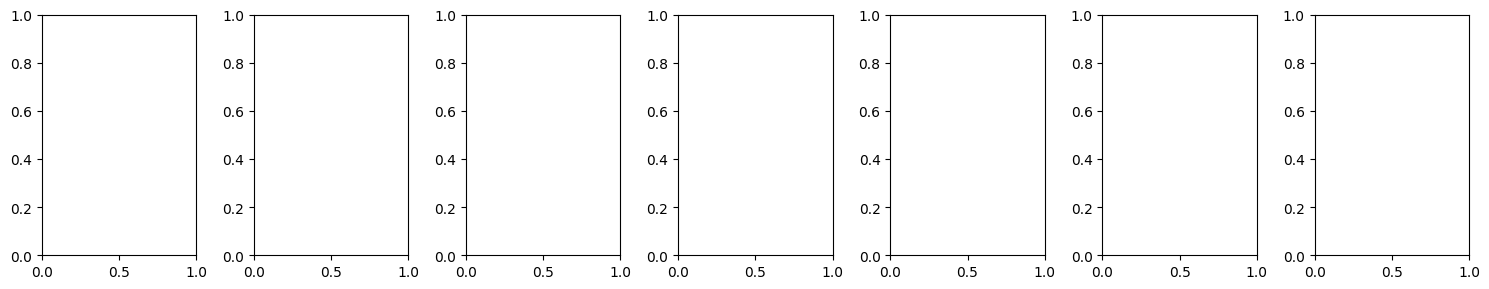

In [3]:
def afficher_logos_notebook():
    #on affiche tous les logos dans le notebook grace a matplotlib
    fig, axes = plt.subplots(1, len(LOGOS), figsize=(15, 3))
    
    for i, logo_name in enumerate(LOGOS):
        logo_path = LOGO_DIR / logo_name
        img = load_image(logo_path, grayscale=False)
        
        if img is not None:
            #on convertit l'image de BGR vers RGB pour l'affichage
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].set_title(logo_name, fontsize=8)
            axes[i].axis('off')
    
    #On ajuste automatiquement l'espacement
    plt.tight_layout()
    plt.show()

afficher_logos_notebook()


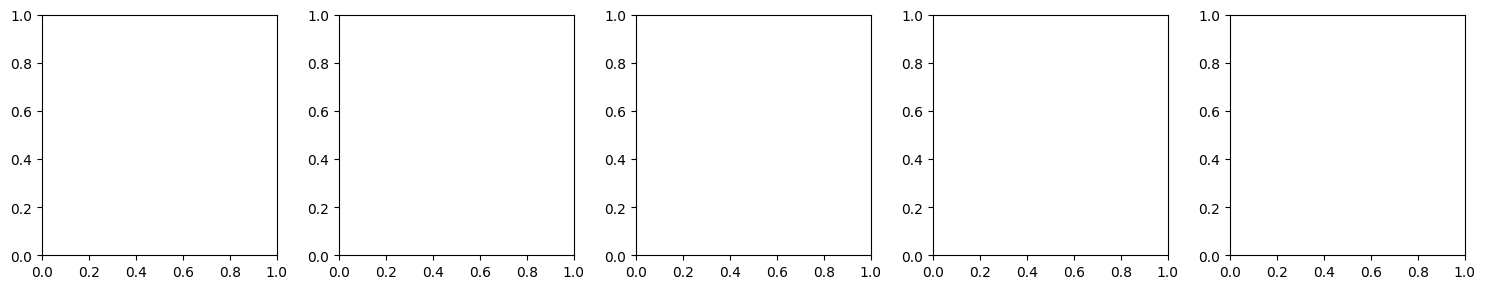

In [4]:
def afficher_images_notebook():
    #on affiche toutes les images du dataset dans le notebook
    fig, axes = plt.subplots(1, len(IMAGES), figsize=(15, 3))
    
    for i, img_name in enumerate(IMAGES):
        img_path = IMAGE_DIR / img_name
        img = load_image(img_path, grayscale=False)
        
        if img is not None:
            #on convertit l'image de BGR vers RGB pour matplotlib
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].set_title(img_name, fontsize=8)
            axes[i].axis('off')
    
    #On ajuste l'espacement pour que les images ne se chevauchent pas
    plt.tight_layout()
    plt.show()

afficher_images_notebook()


## 4. Test du filtre sur une image

In [5]:
#on charge une image de test depuis les logos
test_img_path = LOGO_DIR / LOGOS[0]
img_original = load_image(test_img_path, grayscale=True)

#on applique le filtre à l'image
img_filtree = filter_image(img_original)

#On crée une figure pour afficher les images côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

#On affiche l'image originale en niveaux de gris
axes[0].imshow(img_original, cmap='gray')
axes[0].set_title('Image originale (niveaux de gris)')
axes[0].axis('off')

#On affiche l'image après application du filtre
axes[1].imshow(img_filtree, cmap='gray')
axes[1].set_title('Image après filtre (Canny + dilatation)')
axes[1].axis('off')

#on ajuste l'espacement pour que tout soit lisible
plt.tight_layout()
plt.show()


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\smooth.dispatch.cpp:618: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


## 5. Test de détection ORB sur une paire logo/image

In [ ]:
def tester_detection_simple(index=0):
    #On teste la détection sur une paire logo/image spécifique
    logo_path = LOGO_DIR / LOGOS[index]
    img_path = IMAGE_DIR / IMAGES[index]
    
    print("Test :", LOGOS[index], "vs", IMAGES[index], "\n")
    
    #On charge les images en niveaux de gris
    imgLogo = load_image(logo_path, grayscale=True)
    img = load_image(img_path, grayscale=True)

    if imgLogo is None or img is None:
        print("Erreur de chargement")
        return
    
    #On applique le filtre sur les images
    imgLogo_filtered = filter_image(imgLogo)
    img_filtered = filter_image(img)
    
    #On extrait les keypoints et descripteurs ORB
    kp0, des0 = extraire_features_orb(imgLogo_filtered)
    kp1, des1 = extraire_features_orb(img_filtered)
    
    print("Keypoints logo :", len(kp0))
    print("Keypoints image :", len(kp1))
    
    if des0 is None or des1 is None:
        print("Pas de descripteurs")
        return
    
    #On fait le matching entre les descripteurs
    matches = matcher_logos(des0, des1)
    good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
    
    print("\nMatches totaux :", len(matches))
    print("Bons matches (dist<", SEUIL_DISTANCE, ") :", len(good_matches))
    
    if matches:
        print("Distance min :", round(matches[0].distance, 1))
        print("Distance max :", round(matches[-1].distance, 1))
    
    #On vérifie si la détection est considérée comme valide
    valide = valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE)
    if valide:
        print("Détection valide")
    else:
        print("Détection invalide")

    #On affiche le résultat visuel dans le notebook
    img_matches = dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
    img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 5))
    plt.imshow(img_matches_rgb)
    plt.title("Matching : " + LOGOS[index] + " vs " + IMAGES[index] +" (" + str(len(good_matches)) + " bons matches)")
    plt.axis('off')
    plt.show()

tester_detection_simple(0)


Test : Bershka-logo.png vs BERSHKA.jpg 

Erreur de chargement


In [ ]:
#on teste toutes les paires
for i in range(1, len(LOGOS)):
    tester_detection_simple(i)

## 6. Analyse complète du dataset

In [ ]:
def analyser_dataset_notebook():
    #On lance l'analyse complète du dataset avec affichage dans le notebook
    print("\n"+"FASTFASHOFF - Analyse en cours...")

    #On enregistre le temps de départ pour mesurer la durée de l'analyse
    debut = time.time()     
    marques_detectees = []
    
    for i in range(len(IMAGES)):
        logo_path = LOGO_DIR / LOGOS[i]
        img_path = IMAGE_DIR / IMAGES[i]

        #On charge les images en niveaux de gris
        imgLogo=load_image(logo_path, grayscale=True)
        img=load_image(img_path, grayscale=True)

        if imgLogo is None or img is None:
            print("Impossible de lire :", LOGOS[i], "ou", IMAGES[i])
            continue

        #On applique le filtre sur les images
        imgLogo_filtered=filter_image(imgLogo)
        img_filtered=filter_image(img)

        #On extrait les keypoints et descripteurs ORB
        kp0,des0=extraire_features_orb(imgLogo_filtered)
        kp1,des1=extraire_features_orb(img_filtered)

        if des0 is None or des1 is None:
            print("Pas de descripteurs pour :", LOGOS[i], "ou", IMAGES[i])
            continue

        #On fait le matching entre les descripteurs
        matches=matcher_logos(des0, des1)
        good_matches=filtrer_bons_matches(matches, SEUIL_DISTANCE)
        
        #On vérifie si la détection est valide
    if valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE):
        #On prépare les infos de la détection
        detection = {
            "logo": LOGOS[i],
            "image": IMAGES[i],
            "matches": len(good_matches),
            "distance_min": matches[0].distance if matches else 0
        }
        marques_detectees.append(detection)
        
        print("Logo détecté :", LOGOS[i])
        print("- Nombre de bons matches :", len(good_matches))
        print("- Distance minimale :", round(matches[0].distance, 1))
        
        #On affiche le matching entre le logo et l'image
        img_matches=dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
        img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(15, 5))
        plt.imshow(img_matches_rgb)
        plt.title(LOGOS[i] + " vs " + IMAGES[i] + " - " + str(len(good_matches)) + " matches")
        plt.axis('off')
        plt.show()
        
        #On affiche les informations de boycott pour la marque détectée
        afficher_info_boycott(LOGOS[i])
    else:
        print("Pas de détection :", LOGOS[i], "vs", IMAGES[i])
        print("-Nombre de matches :", len(good_matches), "(minimum requis :", MIN_MATCHES, ")\n")

    
    #On affiche le résumé et les statistiques
    temps_ecoule = time.time() - debut
    afficher_resume(marques_detectees)
    afficher_statistiques_detection(marques_detectees)
    print("Temps d'exécution :", round(temps_ecoule, 2), "s")
    return marques_detectees

#On lance l'analyse
resultats = analyser_dataset_notebook()


## 7. Analyse d'une image spécifique

In [ ]:
def analyser_image_notebook(nom_image):
    #on analyse une image spécifique et on cherche tous les logos
    img_path=IMAGE_DIR / nom_image
    img=load_image(img_path, grayscale=True)
    
    if img is None:
        print("Impossible de lire l'image :", nom_image)
        return
    
    print("Analyse de :", nom_image)
    
    #On applique le filtre à l'image
    img_filtered = filter_image(img)
    
    marques_trouvees = []
    
    for logo_name in LOGOS:
        logo_path= LOGO_DIR / logo_name
        imgLogo = load_image(logo_path, grayscale=True)
        
        if imgLogo is None:
            continue
        
        #on applique le filtre au logo
        imgLogo_filtered=filter_image(imgLogo)
        
        #on extrait les keypoints et descripteurs ORB
        kp0,des0 = extraire_features_orb(imgLogo_filtered)
        kp1,des1 = extraire_features_orb(img_filtered)
        
        if des0 == None or des1 == None:
            continue
        
        #on fait le matching entre logo et image
        matches = matcher_logos(des0, des1)
        good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
        
        #On vérifie si la détection est valide
        if valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE):
            #on enregistre la détection avec le nombre de bons matches et la distance minimale
            marques_trouvees.append({
                "logo": logo_name,
                "matches": len(good_matches),
                "distance_min": matches[0].distance if len(matches) > 0 else 0
            })
            print(logo_name, "détecté (", len(good_matches), "matches )")
            
            #On affiche visuellement le matching
            img_matches = dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
            img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(15, 5))
            plt.imshow(img_matches_rgb)
            plt.title(logo_name + " détecté - " + str(len(good_matches)) + " matches")
            plt.axis('off')
            plt.show()
    
    #On affiche les informations de boycott pour chaque marque détectée
    if marques_trouvees:
        print("Nombre de marque(s) trouvée(s) :", len(marques_trouvees))
        for detection in marques_trouvees:
            afficher_info_boycott(detection['logo'])
    else:
        print("Aucune marque de fast fashion détectée !")
    
    return marques_trouvees

#Exemple : on analyse l'image ZARA
analyser_image_notebook("ZARA.jpeg")

Impossible de lire l'image : ZARA.jpeg


## 8. Interface utilisateur - Analyse d'une image au choix

In [ ]:
def main_for_test():
    #On teste chaque logo contre toutes les images pour trouver les correspondances
    resultats_globaux = []
    
    for logo_name in LOGOS:
        logo_path = LOGO_DIR / logo_name
        imgLogo = load_image(logo_path, grayscale=True)
        
        if imgLogo is None:
            print("Impossible de lire le logo :", logo_name)
            continue
        
        #on applique le filtre au logo
        imgLogo_filtered = filter_image(imgLogo)
        
        #on extrait les keypoints et descripteurs ORB du logo
        kp_logo, des_logo = extraire_features_orb(imgLogo_filtered)
        
        if des_logo is None:
            print("Pas de descripteurs pour le logo :", logo_name)
            continue
        
        print("Recherche de", logo_name, "dans toutes les images :")
        
        meilleur_match = None
        meilleur_score = 0
        
        #on teste ce logo contre toutes les images
        for img_name in IMAGES:
            img_path = IMAGE_DIR / img_name
            img = load_image(img_path, grayscale=True)
            
            if img is None:
                continue
            
            #on applique le filtre à l'image
            img_filtered = filter_image(img)
            
            kp_img, des_img = extraire_features_orb(img_filtered)
            
            if des_img is None:
                continue
            
            #On fait le matching entre logo et image
            matches = matcher_logos(des_logo, des_img)
            good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
            
            valide_geo, nb_inliers = valider_avec_homographie(kp_logo, kp_img, good_matches, 10)
            if len(good_matches) >= MIN_MATCHES and valide_geo:
                print(img_name," : ", str(len(good_matches)),"matches avec", nb_inliers, "inliers, distance min:", round(matches[0].distance,1))
                
                #on garde trace du meilleur match selon le nombre d'inliers
                if nb_inliers > meilleur_score:
                    meilleur_score = nb_inliers
                    meilleur_match = {
                        'image': img_name,
                        'matches': len(good_matches),
                        'inliers': nb_inliers,
                        'distance': matches[0].distance,
                        'kp_logo': kp_logo,
                        'kp_img': kp_img,
                        'img_logo': imgLogo_filtered,
                        'img': img_filtered,
                        'all_matches': matches
                    }
            else:
                if not valide_geo:
                    raison = "géométrie invalide"
                else:
                    raison = "seulement " + str(len(good_matches)) + " matches"
                print("  ", img_name, " : ", raison)
        
        #on affiche le meilleur résultat pour ce logo
        if meilleur_match:
            print("meilleure correspondance pour", logo_name, ":")
            print(meilleur_match['image'],"avec", meilleur_match['inliers'], "inliers et", meilleur_match['matches'], "matches")
            
            resultats_globaux.append({
                'logo': logo_name,
                'image_trouver': meilleur_match['image'],
                'score': meilleur_match['inliers'],
                'matches': meilleur_match['matches']
            })
            
            #On affiche visuellement le meilleur matching
            img_matches = dessiner_matches(
                meilleur_match['img_logo'], meilleur_match['kp_logo'],
                meilleur_match['img'], meilleur_match['kp_img'],
                meilleur_match['all_matches'], 25
            )
            
            img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(15, 5))
            plt.imshow(img_matches_rgb)
            plt.title("MEILLEUR : "+logo_name+" : "+meilleur_match['image']+" (" + str(meilleur_match['inliers']) + " inliers)")
            plt.axis('off')
            plt.show()
        else:
            print("Aucune correspondance valide trouvée pour",logo_name)

    print("Résumé :")
    
    if resultats_globaux:
        for res in resultats_globaux:
            print(res['logo']," : ",res['image_trouvee'],res['score'],"inliers,",res['matches'], "matches")
    else:
        print("Aucune correspondance trouver")
    return resultats_globaux

In [ ]:
resultats = main_for_test()

In [ ]:
def main_for_user():
    #on demande le nom de l'image
    extensions_acceptées = ['.png', '.jpg', '.jpeg']
    nom_fichier = input("Entrez le nom de l'image (avec ou sans extension) : ")
    
    #on vérifie si l'extension est donnée
    if not nom_fichier.lower()[-3:] in extensions_acceptées and not nom_fichier.lower()[-4:] in extensions_acceptées:
        new_ext = input("Entrez l'extension du fichier (avec ou sans le point) : ")
        if new_ext[0] != '.':
            new_ext = '.' + new_ext
        nom_fichier += new_ext
    
    #on regarde si le fichier existe
    img_path = IMAGE_DIR / nom_fichier
    if not img_path.exists():
        print("erreur :", nom_fichier, "n'existe pas dans", IMAGE_DIR)
        print("images disponibles :")
        for img in IMAGES:
            print(" -", img)
        return
    
    #on charge l'image
    print("analyse de l'image :", nom_fichier)
    img = load_image(img_path, grayscale=True)
    if img == None:
        print("impossible de charger l'image")
        return
    
    img_filtrée = filter_image(img)
    marques_trouvées = []
    
    #on teste tous les logos
    for logo_name in LOGOS:
        logo_path = LOGO_DIR / logo_name
        img_logo = load_image(logo_path, grayscale=True)
        if img_logo == None:
            continue
        
        img_logo_filtrée = filter_image(img_logo)
        
        kp_logo,des_logo = extraire_features_orb(img_logo_filtrée)
        kp_img,des_img = extraire_features_orb(img_filtrée)
        if des_logo == None or des_img == None:
            continue

        matches = matcher_logos(des_logo, des_img)
        bons_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
        
        #on vérifie si la détection est valide
        if valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE):
            marques_trouvées.append({
                'logo': logo_name,
                'matches': len(bons_matches),
                'distance_min': matches[0].distance
            })
            print(logo_name, "détecté avec", len(bons_matches), "bons matches")
            img_matches = dessiner_matches(img_logo_filtrée, kp_logo, img_filtrée, kp_img, matches, 25)
            img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(15, 5))
            plt.imshow(img_matches_rgb)
            plt.title(logo_name + " détecté - " + str(len(bons_matches)) + " matches")
            plt.axis('off')
            plt.show()
    
    #on affiche les infos de boycott si des logos ont été détécter
    if marques_trouvées:
        print(len(marques_trouvées), "marque(s) de fast fashion trouvée(s) :")
        for detection in marques_trouvées:
            afficher_info_boycott(detection['logo'])
    else:
        print("aucune marque de fast fashion détectée")
    
    return marques_trouvées


In [ ]:
main_for_user()

## 9. Tests et expérimentations

In [ ]:
def comparer_seuils():
    #on teste différents seuils de détection
    seuils_distance = [30, 40, 50, 60]
    seuils_min_matches = [10, 15, 20, 25]
    
    print("comparaison des seuils de détection :")
    
    resultats_comparaison = []
    
    for seuil_dist in seuils_distance:
        for min_match in seuils_min_matches:
            print("test avec seuil distance =", seuil_dist, "et min matches =", min_match)
            
            detections = 0
            total_matches = 0
            
            #on parcourt toutes les images
            for i in range(len(IMAGES)):
                logo_path = LOGO_DIR / LOGOS[i]
                img_path = IMAGE_DIR / IMAGES[i]
                
                img_logo = load_image(logo_path, grayscale=True)
                img = load_image(img_path, grayscale=True)
                
                if img_logo == None or img == None:
                    continue
                
                img_logo_filtrée = filter_image(img_logo)
                img_filtrée = filter_image(img)
                
                kp_logo, des_logo = extraire_features_orb(img_logo_filtrée)
                kp_img, des_img = extraire_features_orb(img_filtrée)
                
                if des_logo == None or des_img == None:
                    continue
                
                matches = matcher_logos(des_logo, des_img)
                bons_matches = filtrer_bons_matches(matches, seuil_dist)
            
                if valider_detection(matches, min_match, seuil_dist):
                    detections += 1
                    total_matches += len(bons_matches)
            
            print("detections :", detections, "sur", len(IMAGES))
            print("total bons matches :", total_matches)
            
            resultats_comparaison.append({
                "seuil_distance": seuil_dist,
                "min_matches": min_match,
                "detections": detections,
                "total_matches": total_matches
            })
    
    #on affiche les résultats
    print("résultats de la comparaison des seuils :")
    for res in resultats_comparaison:
        print("avec seuil distance", res['seuil_distance'], 
            "et min matches", res['min_matches'], 
            "→ détections :", res['detections'], 
            ", total de bons matches :", res['total_matches'])
    return resultats_comparaison

resultats_seuils = comparer_seuils()


## 10. Informations sur les marques

In [ ]:
def afficher_toutes_marques():
    #on affiche les infos de chaque marque
    print("base de données des marques :")
    
    for marque_key, info in MARQUES_INFO.items():
        print("marque : ",info['nom_complet'])
        print("faits : ",info['faits'])
        print("raisons principales :")
        for i, raison in enumerate(info['raisons'][:3], 1):
            print(i," : ", raison)
        print("alternatives : ",info['alternatives'])
        
afficher_toutes_marques()


## 11. Conclusion et perspectives


## 12. Ressources et références

### Documentation utilisée
- [OpenCV Documentation](https://docs.opencv.org/)
- [ORB Feature Detection](https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html)
- [Feature Matching](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)

### Sources sur la fast fashion
- Clean Clothes Campaign : https://cleanclothes.org/
- Fashion Revolution : https://www.fashionrevolution.org/
- Documentaire "The True Cost" (2015)
- Rapport Changing Markets Foundation

### Marques éthiques alternatives
- Good On You : https://goodonyou.eco/
- Clear Fashion : https://clearfashion.com/
- Slow Fashion Movement

In [ ]:
print("Notebook terminé")
print("Pour relancer l'analyse complète : analyser_dataset_notebook()")
print("Pour analyser une image : analyser_image_notebook('nom_fichier.jpg')")
print("Pour générer un rapport : generer_rapport_markdown(resultats)")
